In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd

In [37]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [41]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


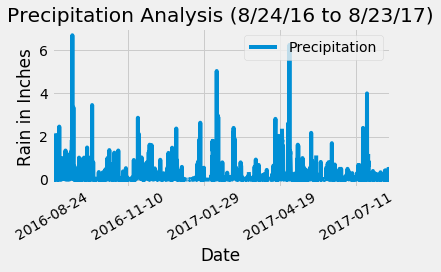

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(lastest_date)

# Calculate the date 1 year ago from the last data point in the database
lastest_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(lastest_year)

# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > lastest_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data)
rain_df.head()

# Sort the dataframe by date

rain_df.set_index('date').head()
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


![precipitation](Images/precipitation.png)

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [59]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")


Station Count: 9


In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [63]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stationID = stationCounts[0][0]
stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


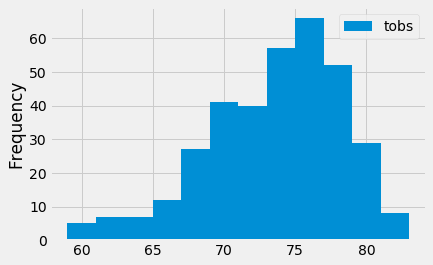

In [74]:
# Choose the station with the highest number of temperature observations.
# Query for the last year of temperature data
#query for the last year of temperature data
tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

#convert query object to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

#sory by date
tempTable = tempTable.sort_index(ascending=True)

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)




![precipitation](Images/station-histogram.png)

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)



[(67.0, 74.47368421052632, 82.0)]


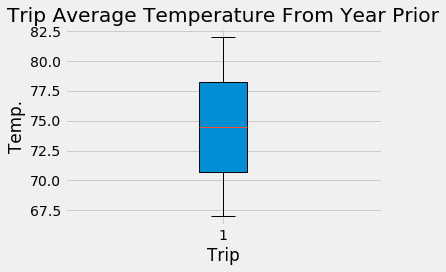

In [70]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temperature From Year Prior')
ax.set_ylabel("Temp.")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

In [78]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_arrive)
                   .filter(Measurement.date <= trip_leave)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())


stationRainTable = pd.DataFrame(np.array(stationRain))




In [80]:
!pip install flask


SyntaxError: unexpected EOF while parsing (<ipython-input-81-f9b9d598ba29>, line 10)

## Optional Challenge Assignment

In [82]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [83]:
startDate = "2019-08-08"
endDate = "2019-08-19"


startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1


startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')

dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

tripNormals = [daily_normals(date) for date in dateList]

tripNormals


[[(68.0, 76.5576923076923, 83.0)],
 [(69.0, 75.98039215686275, 81.0)],
 [(65.0, 76.42, 83.0)],
 [(67.0, 75.98113207547169, 82.0)],
 [(67.0, 76.52727272727273, 83.0)],
 [(71.0, 76.98245614035088, 84.0)],
 [(71.0, 76.77777777777777, 82.0)],
 [(69.0, 76.47169811320755, 83.0)],
 [(69.0, 76.08, 83.0)],
 [(69.0, 76.125, 83.0)],
 [(70.0, 76.92307692307692, 84.0)],
 [(69.0, 75.94642857142857, 85.0)]]

In [84]:
tripNormals = [np.array(normal[0]) for normal in tripNormals]
normalsTable = pd.DataFrame(tripNormals)
normalsTable["Date"] = dateList
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable


,Low Temp,Avg Temp,High Temp
Date,,,
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0


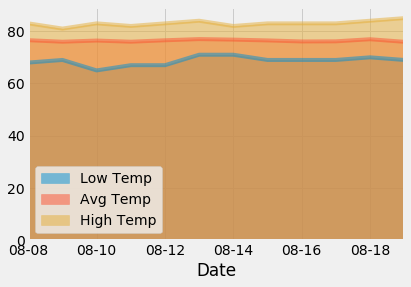

In [89]:
# Plot the daily normals as an area plot with `stacked=False`
normalsTable.plot.area(stacked=False, alpha=.50)
